# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations
 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


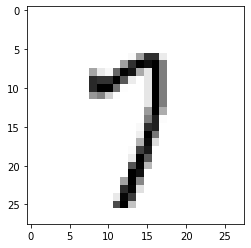

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[-1].numpy().squeeze(), cmap='gray_r')


# The model


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        ) # output_size = 28, RF - 3
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        ) # output_size = 28, RF - 5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14, RF - 6


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        ) # output_size = 14, RF - 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        ) # output_size = 14, RF - 14
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 7, RF - 16
      

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 5, RF - 24
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
        ) # output_size = 3, RF - 32
         
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,304
              ReLU-4           [-1, 16, 28, 28]               0
         MaxPool2d-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           4,608
              ReLU-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]           9,216
              ReLU-9           [-1, 32, 14, 14]               0
        MaxPool2d-10             [-1, 32, 7, 7]               0
           Conv2d-11             [-1, 64, 5, 5]          18,432
             ReLU-12             [-1, 64, 5, 5]               0
           Conv2d-13             [-1, 64, 3, 3]          36,864
           Conv2d-14             [

# Training and Testing


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    
    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.6193240880966187 Batch_id=468 Accuracy=27.63: 100%|██████████| 469/469 [00:09<00:00, 48.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4436, Accuracy: 8494/10000 (84.94%)

EPOCH: 1


Loss=0.057605426758527756 Batch_id=468 Accuracy=92.31: 100%|██████████| 469/469 [00:10<00:00, 46.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1557, Accuracy: 9493/10000 (94.93%)

EPOCH: 2


Loss=0.08012863248586655 Batch_id=468 Accuracy=96.37: 100%|██████████| 469/469 [00:09<00:00, 47.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1162, Accuracy: 9608/10000 (96.08%)

EPOCH: 3


Loss=0.11314467340707779 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:10<00:00, 46.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0607, Accuracy: 9803/10000 (98.03%)

EPOCH: 4


Loss=0.1411179006099701 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:09<00:00, 47.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9834/10000 (98.34%)

EPOCH: 5


Loss=0.03997102007269859 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:09<00:00, 47.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9853/10000 (98.53%)

EPOCH: 6


Loss=0.04874582216143608 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:10<00:00, 46.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9860/10000 (98.60%)

EPOCH: 7


Loss=0.04204345867037773 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:09<00:00, 48.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9898/10000 (98.98%)

EPOCH: 8


Loss=0.04079430177807808 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:09<00:00, 48.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9873/10000 (98.73%)

EPOCH: 9


Loss=0.07936098426580429 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:09<00:00, 47.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9884/10000 (98.84%)

EPOCH: 10


Loss=0.0355055071413517 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:09<00:00, 47.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9887/10000 (98.87%)

EPOCH: 11


Loss=0.008568729273974895 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:09<00:00, 47.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9891/10000 (98.91%)

EPOCH: 12


Loss=0.03329969570040703 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:10<00:00, 46.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


Loss=0.005998244043439627 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:09<00:00, 48.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9848/10000 (98.48%)

EPOCH: 14


Loss=0.03396255895495415 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:10<00:00, 46.64it/s]



Test set: Average loss: 0.0255, Accuracy: 9922/10000 (99.22%)



Text(0.5, 1.0, 'Test Accuracy')

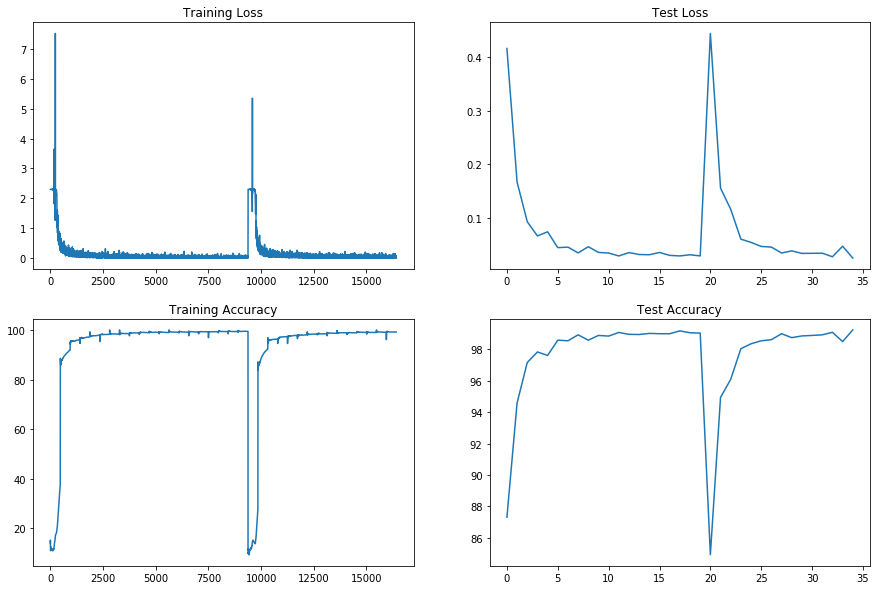

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")